## Adversarial Attacks using adversarial samples (FGSM)

Adversarial Examples are the well designed samples with an intention to cause machine learning to make mistake. This is done using the **Fast Gradient Sign Method**.
FGSM involves adding noise (not random noise) whose direction is the same as the gradient of the cost function with respect to the data. The noise is scaled by epsilon, which is usually constrained to be a small number. The magnitude of gradient does not matter in this formula, but the direction (+/-).
<br><br>
White box attacks are those type of attacks where the attacker has access to the model's parameters. FGSM is a white box attack which uses the gradient to create adversarial examples. Since we cannot change the weights, in order to increase the cost, the only way is to change the data and thus we maxmimise the loss/cost.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
credit_data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Preprocessing portion
features = credit_data.drop("Class", axis=1)
target = credit_data.Class

N, D = features.shape

# Convert 1D array of targets to 2D numpy array of N rows and 1 column (target column).
Y = np.reshape(target.values, (N, 1))
X = features[['V1', 'Amount']].values

def preprocess(features, targets):
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=credit_data['Class'], random_state=0)
  return X_train, X_test, y_train, y_test

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def loss_function(y, y_hat):
  """
  This function uses the log likelihood function as the loss/cost function.
  """
  y = y.flatten()
  y_hat = y_hat.flatten()

  cost = 0
  elp = 0.0000000000000000000000000000000000000000000001   # small error
  for i in range(len(y)):
      cost -= y[i] * np.log(y_hat[i] + elp) + (1 - y[i]) * np.log(1 - y_hat[i] + elp)
  return cost

def predict(weights, beta, X):
  z = np.matmul(weights.T, X.T) + beta
  result = sigmoid(z)
  return result

def predict_class(weights, beta, X):
  predicted_class = predict(weights, beta, X)
  return (predicted_class >= 0.5) * 1

In [ ]:
def error_rate(Y, P):
  return np.mean(Y != P)

In [ ]:
# Logistic Regression function 

def logistic_regression(X, Y, learning_rate=0.0000003, epoch=1000):
  """
  This function fits the data into the logistic regression model.
  - Uses batch gradient descent 
  - Algorithm uses number of epochs as termination condition
  - Cost function: Log Likelihood function

  Arguments: 
    X - features
    Y - labels/target
    learning_rate - learning_rate for the algorithm
    epochs - Number of iterations.
  """
  # Changing the datatypes of the features and target 
  X = np.array(X, dtype="float32")
  Y = np.array(Y, dtype="float32")
  
  # Computind dimensions of X
  N, D = X.shape
  Y = Y.reshape(N, 1)
  
  # Initialising
  dlt = np.zeros([N, 1], dtype="float32")
  dW = np.zeros([1, D], dtype="float32")
  db = 0
  weights = np.zeros([D, 1], dtype="float32")
  beta = 0
  c = []
  
  for n in range(epoch): # Termination is based on number of epochs
      dlt = predict(weights, beta, X).T - Y  # X - row-wise vector, Y - column-wise vector, dlt - column wise vector
      dW = np.matmul(dlt.T, X).T # dW - column vector 
      db = dlt.sum() / N 

      weights -= learning_rate * dW
      beta -= learning_rate * db
      if n % 1000 == 0:   
          c_new = loss_function(Y, predict(weights, beta, X).T) 
          # print("Self.predict: ", predict(weights, beta, X).T)  # column vector
          c.append(c_new)
          err = error_rate(Y, predict_class(weights, beta, X).T)
          print("-------------------------------------------------------------------------------------------------")
          print("Epoch: ", n//1000)
          print("Error Rate: ", err)
          print("Weights: ", weights.T)
          print("Cost: ", c_new)
          print("---------------------------------------------------------------------------------------------------")
  return weights, beta
      

## Logistic Regression without Adversarial Samples

Here we train the model and obtain the weights of the model

In [ ]:
X = features[['V1', 'V2']]
Y = credit_data['Class']
Y = np.reshape(Y.values, (N, 1))
train_x, test_x, train_y, test_y = preprocess(X, Y)

In [ ]:
# Logistic Regression without Adversarial Samples
weights, beta = logistic_regression(X, Y, learning_rate=0.0005, epoch=20000)

-------------------------------------------------------------------------------------------------
Epoch:  0
Error Rate:  0.5034672602850351
Weights:  [[-1.1738994  0.891449 ]]
Cost:  386073.8591733851
---------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-------------------------------------------------------------------------------------------------
Epoch:  1
Error Rate:  0.5137338618783949
Weights:  [[-91.30791  32.79654]]
Cost:  14971366.584786674
---------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
Epoch:  2
Error Rate:  0.5135758601438869
Weights:  [[-92.810356  33.222885]]
Cost:  14970751.073567117
---------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
Epoch:  3
Error Rate:  0.5136601277356245
Weights:  [[-94.66993   23.979391]]
Cost:  14668117.327492265
---------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

In [ ]:
y_pred_train_org = predict_class(weights, beta, train_x.values).T
print("Training Results")
print('Error Rate without adversarial examples:', error_rate(train_y.values.reshape(train_x.shape[0], 1), predict_class(weights, beta, train_x.values).T))
print("Testing Results")
print('Error Rate without adversarial examples:', error_rate(test_y.values.reshape(test_x.shape[0], 1), predict_class(weights, beta, test_x.values).T))
y_pred_test_org = predict_class(weights, beta, test_x.values).T

Training Results
Error Rate without adversarial examples: 0.4631678738388074
Testing Results
Error Rate without adversarial examples: 0.4637009468300504


## Logistic Regression with Adversarial Samples (FGSM Method)

* In gradient descent, the gradient of cost is with respect to weight
* In adversarial examples, the gradient of cost is with respect to data 

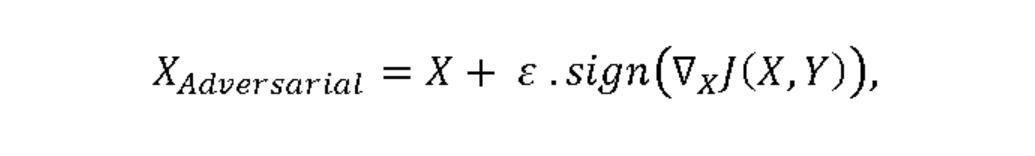

In [ ]:
def adversial_samples(X, Y, weights, beta, epsilon=0.00001):
    dlt = predict(weights, beta, X).T - Y.reshape(X.shape[0], 1)
    direction = np.sign(np.matmul(dlt, weights.T))
    return X + epsilon * direction, Y

In [ ]:
# Here we tweak the gradient and make predictions
Xadv, Yadv = adversial_samples(test_x.values, test_y.values, weights, beta, epsilon=0.5)
y_pred_adv = predict_class(weights, beta, Xadv).T
print('Error Rate with adversarial examples, epsilon = 0.5:', error_rate(Yadv.reshape(Xadv.shape[0], 1), predict_class(weights, beta, Xadv).T))

Xadv2, Yadv2 = adversial_samples(test_x.values, test_y.values, weights, beta, epsilon=3.5)
y_pred_adv2 = predict_class(weights, beta, Xadv2).T
print('Error Rate with adversarial examples, epsilon = 3.5:', error_rate(Yadv2.reshape(Xadv2.shape[0], 1), predict_class(weights, beta, Xadv2).T))


Error Rate with adversarial examples, epsilon = 0.5: 0.5011177042004611
Error Rate with adversarial examples, epsilon = 3.5: 0.9695001345926524


## Evaluation metrics

In [ ]:
# Function to calculate the accuracy
def accuracy_results(preds, y_true):
  tp = 0
  tn = 0
  fp = 0 
  fn = 0

  for i in range(len(preds)):
    if preds[i] == 1 and y_true[i] == 1:
      tp += 1
    elif preds[i] == 1 and y_true[i] == 0:
      fp += 1
    elif preds[i] == 0 and y_true[i] == 0:
      tn += 1
    elif preds[i] == 0 and y_true[i] == 1:
      fn += 1
  acc = (tp + tn) / (tp + fp + fn + tn) 
  return acc

# Function to calculate the precision, recall and F1-score
def precision_recall_f1_score(preds, y_true):
  tp = 0
  tn = 0
  fn = 0
  fp = 0
  p = 0
  n = 0
  precision = 0
  recall = 0
  f1_score = 0
  tpr = 0
  fpr = 0
  for i in range(len(y_true)):
    if y_true[i] == 0:
      n += 1
    else:
      p += 1
  for i in range(len(preds)):
    if preds[i] == 1 and y_true[i] == 1:
      tp += 1
    elif preds[i] == 1 and y_true[i] == 0:
      fp += 1
    elif preds[i] == 0 and y_true[i] == 0:
      tn += 1
    elif preds[i] == 0 and y_true[i] == 1:
      fn += 1

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  if precision != 0 and recall != 0:
    f1_score = (2 * precision * recall) / (precision + recall)
  tpr = tp / p
  fpr = fp / n
  if precision != 0 and recall != 0 and f1_score != 0 and tpr != 0 and fpr != 0:
    return (precision, recall, f1_score, tpr, fpr)
  else:
    return (0, 0, 0, 0, 0)  

In [ ]:
predictions = [y_pred_test_org, y_pred_adv, y_pred_adv2]
labels = ["Original", "Adversarial with 0.5 error", "Advarsarial with 3.5 error"]
accuracies = []

for i in range(len(predictions)):
  pred = predictions[i]
  acc = accuracy_results(pred, test_y.values)
  accuracies.append(acc)
  precision, recall, f1_score, tpr, fpr = precision_recall_f1_score(pred, test_y.values)
  print("-----------------------------------------------------------------------------------------------")
  print(f"\Tag: {labels[i]}\n")
  print(f"Accuracy: {acc}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1_score}")
  print(f"TPR: {tpr} \nFPR:{fpr}")
  print("-----------------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------------
\Tag: Original

Accuracy: 0.9906604402935291
Precision: 0.028985507246376812
Recall: 0.13513513513513514
F1-score: 0.04773269689737471
TPR: 0.13513513513513514 
FPR:0.00785509115422944
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
\Tag: Adversarial with 0.5 error

Accuracy: 0.9729878398464473
Precision: 0.00684931506849315
Recall: 0.10135135135135136
F1-score: 0.012831479897348159
TPR: 0.10135135135135136 
FPR:0.025499736209625416
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
\Tag: Advarsarial with 3.5 error

Accuracy: 0.7830249406036773
Precision: 0.0008142880408229738
Recall: 0.10135135135135136
F1-scor

In [ ]:
import itertools

def plot_confusion_matrix(test, preds):
  figsize = (10, 10)

  # Create the confusion matrix
  cm = confusion_matrix(test, preds)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Create classes
  classes = False

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.xaxis.label.set_size(20)
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=15)

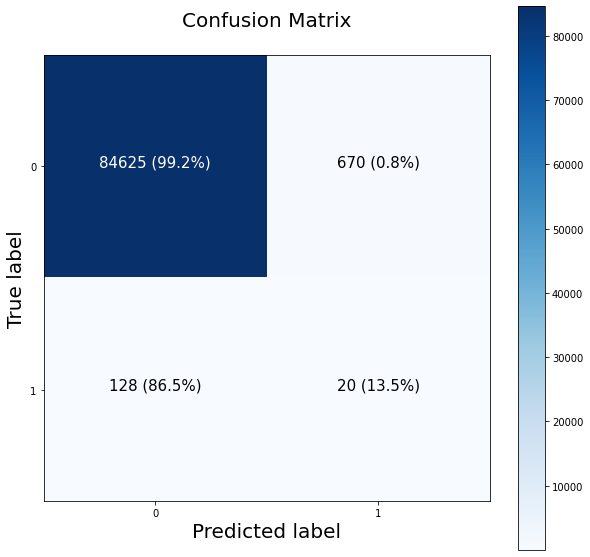

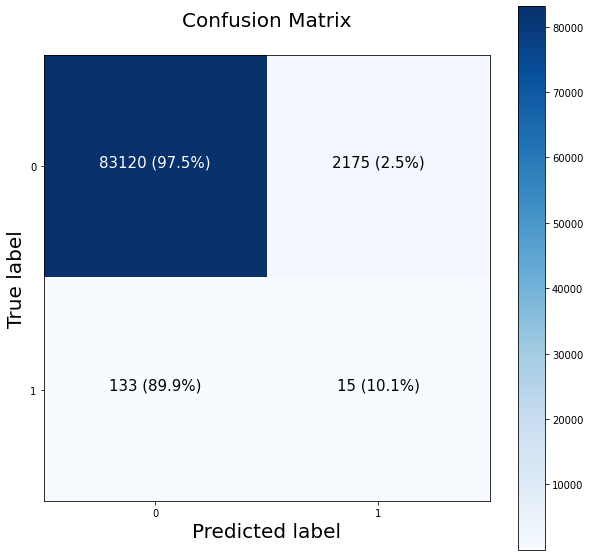

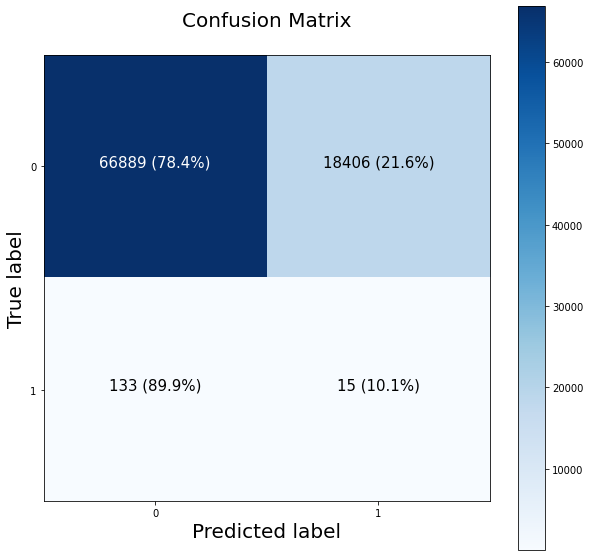

In [ ]:
for i in range(len(predictions)):
  plot_confusion_matrix(test_y.values, predictions[i])

## Visual Representation

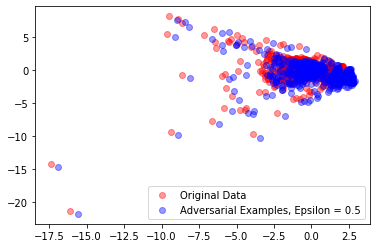

In [ ]:
plt.scatter(test_x.values[:999, 0], test_x.values[:999, 1], color='red', alpha=0.4, label='Original Data')
plt.scatter(Xadv[:999, 0], Xadv[:999, 1], color='blue', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()

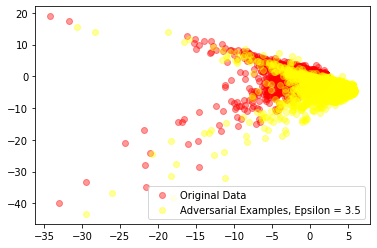

In [ ]:
plt.scatter(test_x.values[:9999, 0], test_x.values[:9999, 1], color='red', alpha=0.4, label='Original Data')
plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 3.5')
plt.legend(loc='best')
plt.show()